# 1.10 Get Dow 30 CIK

In [2]:
import pandas as pd
import requests

In [3]:
def get_dow_30_cik():
    url = 'https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average'
    df_list = pd.read_html(url)
    df1 = df_list[1]
    ticker_url = "https://www.sec.gov/include/ticker.txt"
    page = requests.get(ticker_url)
    data = []
    for line in page.text.split("\n"):
        symbol, cik = line.split("\t")
        data.append([symbol, cik])
    # put this into a table, and merge if table has common value of ticker symbol
    df2 = pd.DataFrame(data, columns = ['Symbol', 'CIK'])
    df2['Symbol'] = df2['Symbol'].str.upper() 
    master = pd.merge(df1, df2, on="Symbol", how="left")
    master["CIK"] = pd.to_numeric(master["CIK"])
    return master

# 1.1 Download files function
- Given url, filename, download the file from url to filename
- Can show progress bar in jupyter for ease of viewing

In [ ]:
import requests
import tqdm
from tqdm.auto import tqdm
from pathlib import Path

In [ ]:
# fname is full path to file
# show_progress_bar is used during debug

def download(url, fname, show_progress_bar=False, override=False):
    fpath = Path(fname)
    if fpath.is_file() and not override:
        if show_progress_bar:
            print("File {} already exist".format(fname))
        return "File Exists"
    
    else:
        if show_progress_bar:
            response = requests.get(url, stream=True)
            with tqdm.wrapattr(
                open(fname, "wb"),
                "write",
                miniters=1,
                total=int(response.headers.get('content-length', 0)),
                desc=fname
            ) as fout:
                for chunk in response.iter_content(chunk_size=4096):
                    fout.write(chunk)
        else:
            with requests.get(url, stream=True) as r:
                    with open(fname, "wb") as f:
                        for chunk in r.iter_content(chunk_size=4096): 
                            f.write(chunk)
        return "File Downloaded"


# 1.2 Download files concurrently function
- Given url, filename, download the file from url to filename
- Can show progress bar in jupyter for ease of viewing

In [1]:
import threading
import time

In [2]:
# urls_with_fname_array
# [(url, fname), (url, fname), ...]

def download_concurrently(
    urls_with_fname_array, 
    max_concurrent_downloads=10, 
    show_progress_bar=False, 
    additional_sleep=0.1, 
    override=False
):
    
    files_downloaded = 0

    def thread_function(urls, fname, show_progress_bar):
        download(urls, fname, show_progress_bar, override=override)

    for urls, fname in urls_with_fname_array:
        x = threading.Thread(target=thread_function, args=(urls, fname, show_progress_bar))
        x.start()
        files_downloaded += 1
        if (files_downloaded % max_concurrent_downloads) == 0:
            time.sleep(additional_sleep)

# 1.5 Get idx dataframe

In [2]:
from pathlib import Path
import pandas as pd

In [3]:
def obtain_dataframe(cik_list, start_of_date_range=2005, end_of_date_range=2021, form_type="4"):
    root_dir = Path('.')
    index_files_dir = root_dir / "index_files"
    index_files_dir.mkdir(parents=True, exist_ok=True)
    host = "https://www.sec.gov/Archives"
    data_files_dir = root_dir / "data_files"
    data_files_dir.mkdir(parents=True, exist_ok=True)

    master_frame = []

    rows = [i for i in range(9)]
    rows.append(10)

    for year in range(start_of_date_range, end_of_date_range):
        for quarter_index in range(1, 5):
            quarter = "QTR{}".format(quarter_index)
            year_quarter_dir = data_files_dir / "{}".format(year) / "{}".format(quarter)
            year_quarter_dir.mkdir(parents=True, exist_ok=True)
            fname = "{}-{}.idx".format(year, quarter)
            full_dir = index_files_dir / fname
            try:
                df = pd.read_csv(
                    str(full_dir.absolute()),
                    sep='|',
                    skiprows=rows,
                )
                form4 = df.loc[(df['CIK'].isin(cik_list)) & (df['Form Type'] == form_type)]
                for i, row in form4.iterrows(): 
                    file_url = "{}/{}".format(host, row["Filename"])
                    row["Year"] = "{}".format(year)
                    row["Quarter"] = quarter
                    
                    accession_number = row["Filename"].split("/")[-1].split(".")[0]
                    row["Accession Number"] = accession_number
                    
                    filename = row["Filename"].split("/")[-1]
                    year_quarter_dir = data_files_dir / "{}".format(row["Year"]) / "{}".format(row["Quarter"])
                    year_quarter_dir.mkdir(parents=True, exist_ok=True)
                    new_filepath = year_quarter_dir / filename
                    file_url = "{}/{}".format(host, row["Filename"])
                    
                    row["Filepath"] = str(new_filepath.absolute())
                    row["Fileurl"] = file_url
                    
                    
                    master_frame.append(row)
            except Exception as e:
                print(e)
                print(str(full_dir.absolute()))
                
    master_frame = pd.DataFrame(master_frame)
    return master_frame

# 1.7 Download CIK textfiles

In [2]:
from pathlib import Path

In [4]:
def download_txt_files_for_cik_list(
    cik_list, 
    concurrent=False, 
    show_progress_bar=True, 
    start_of_date_range=2005, 
    end_of_date_range=2021, 
    form_type="4",
    override=False, 
    additional_sleep_for_concurrent=0.1,
    max_files_count=None
):    
    master_frame = obtain_dataframe(cik_list, start_of_date_range, end_of_date_range, form_type)
    
    if concurrent:
        urls_with_fname_array = []
        for i, row in master_frame.iterrows():
            urls_with_fname_array.append((row["Fileurl"], row["Filepath"]))
        download_concurrently(
            urls_with_fname_array, 
            show_progress_bar=show_progress_bar,
            override=override,
            additional_sleep=additional_sleep_for_concurrent
            )
    else:
        count = 0
        file_exists_count = 0
        file_downloaded_count = 0
        for i, row in master_frame.iterrows():
            if max_files_count is not None:
                if count >= max_files_count:
                    break
            #print("Downloading {}".format(row["Fileurl"]))
            status = download(
                row["Fileurl"], 
                row["Filepath"], 
                show_progress_bar=show_progress_bar,
                override=override
            )
            if status == "File Exists":
                file_exists_count += 1
            elif status == "File Downloaded":
                file_downloaded_count += 1
            count += 1
        outcome = {
            "total_files": master_frame.shape[0],
            "file_exists_count": file_exists_count,
            "file_downloaded_count": file_downloaded_count,
        }
        return outcome

# 2.1 Generate CSV from CIK List

In [2]:
import requests
from bs4 import BeautifulSoup
from pathlib import Path
import csv
import pandas as pd

In [23]:
def big_picture_xml_processing(soup, file):
    def obj_find(obj, key, ignore_exception=False):
        if obj:
            result = obj.find(key)
            if result:
                return result 
            else:
                if ignore_exception:
                    return None
                else:
                    print("Error finding {}".format(key))
                    open_txt(str(file.absolute()))
                    raise Exception("Error found. Loop stopped at {}".format(file))
                
                
    def obj_get_text(obj):
        if obj:
            return obj.getText()
    
    xml_data = obj_find(soup, "xml")
    reportingowner = obj_find(xml_data, "reportingowner")
    rptownercik = obj_find(reportingowner, "rptownercik")
    cik = obj_get_text(rptownercik)

    transactiondate = obj_find(xml_data, "transactiondate", ignore_exception=True)
    if not transactiondate:
        return None
    transactiondate_value = obj_find(xml_data, "value")
    date = obj_get_text(transactiondate_value)

    rptownername = obj_find(reportingowner, "rptownername")
    r = obj_get_text(rptownername)


    def get_role_from_xml_data(xml_data):
        role_id = 0
        # isdirector = 1
        # isofficer = 2
        # istenpercentowner = 3
        # isother = 4
        for role in soup.find("xml").find("reportingownerrelationship").findChildren():
            if role.text == "1":
                role_name = role.name
                if role_name == "isdirector":
                    role_id = 1
                elif role_name == "isofficer":
                    role_id = 2
                elif role_name == "istenpercentowner":
                    role_id = 3
                elif role_name == "isother":
                    role_id = 4
                break
        return role_id

    role = get_role_from_xml_data(xml_data)
    
    processed_obj = {
        'CIK': cik,
        "Filing Date": date,
        "Form Type": "4",
        "Reporting Person": r,
        "Role Code": role
    }
    
    return processed_obj

def details_xml_processing(soup):
    
    xml_data = soup.find("xml")
    output = []
    def get_value_of_element_by_find(el, tag):
        result = "-"
        obj = el.find(tag)
        if obj:
            value = obj.find("value")
            if value:
                result = value.getText()
        return result

    try:
        nonderivative_table = xml_data.find("nonderivativetable")
        if nonderivative_table:
            for transaction_xml in nonderivative_table.find_all("nonderivativetransaction"):

                def get_role_from_xml_data(xml_data):
                    transaction_type = 0
                    # purchase = 1
                    # sale = 2
                    transaction_type_str = get_value_of_element_by_find(xml_data, "transactionacquireddisposedcode")
                    if transaction_type_str == "A":
                        transaction_type = 1
                    elif transaction_type_str == "D":
                        transaction_type = 2
                    return transaction_type

                title = get_value_of_element_by_find(transaction_xml, "securitytitle")
                date = get_value_of_element_by_find(transaction_xml, "transactiondate")
                shares_amount = get_value_of_element_by_find(transaction_xml, "transactionshares")
                price_per_share = get_value_of_element_by_find(transaction_xml, "transactionpricepershare")

                transaction_type = get_role_from_xml_data(transaction_xml)
                
                processed_data = {
                    'ACQDISP': transaction_type,
                    "TRANDATE": date,
                    "TPRICE": price_per_share,
                    "SHARES": shares_amount
                }
                output.append(processed_data)
                
            return output
            
    except AttributeError:
        #print("Attribute Error")
        print("\nAttribute Error {}".format(file.resolve()))
        view_url = "https://www.sec.gov/Archives/edgar/data/{}/{}/{}-index.html".format(cik, accession_number.replace("-", ""), accession_number)
        print(view_url)
        import pdb; pdb.set_trace()
        
    return output

def write_to_big_picture(data):
    with open('big_picture.csv', mode='w') as f:
        writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        writer.writerow([
            'Year-Quarter', 
            'Accession Number', 
            'CIK',
            "Filing Date",
            "Form Type",
            "Reporting Person",
            "Role Code"
        ])
        
        for row in data:       
            writer.writerow(row)
            
def write_to_details(data):
    with open('details.csv', mode='w') as f:
        writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

        writer.writerow([
            'Year-Quarter', 
            'Accession Number', 
            'ACQDISP',
            "TRANDATE",
            "TPRICE",
            "SHARES",
        ])
        
        for row in data:       
            writer.writerow(row)
        
def generate_csv_for_cik_list(cik_list, start_of_date_range=2005, end_of_date_range=2021, form_type="4", max_files_count=None):
    
    big_picture_xml_array = []
    details_xml_array = []
    
    master_frame = obtain_dataframe(cik_list, start_of_date_range, end_of_date_range, form_type)
    
    count = 0
    for i, row in master_frame.iterrows():
        if max_files_count is not None:
            if count >= max_files_count:
                break
        print(count)
        accession_number = row["Accession Number"]
        year = row["Year"]
        quarter = row["Quarter"]
        file = Path(row["Filepath"])
        if file.is_file():
            with open(file, "r") as f:
                soup = BeautifulSoup(f, "lxml")
                if soup.find("title"):
                    if soup.find("title").getText() == "SEC.gov | Request Rate Threshold Exceeded":
                        continue
                big_picture_data = big_picture_xml_processing(soup, file)
                if not big_picture_data:
                    continue
                big_picture_row = [
                    "{}-{}".format(year, quarter),
                    "{}".format(accession_number),
                    "{}".format(big_picture_data["CIK"]),
                    "{}".format(big_picture_data["Filing Date"]),
                    "{}".format(big_picture_data["Form Type"]),
                    "{}".format(big_picture_data["Reporting Person"]),
                    "{}".format(big_picture_data["Role Code"]),
                ]
                big_picture_xml_array.append(big_picture_row)
                
                details_data = details_xml_processing(soup)
                if len(details_data) != 0:
                    for details_data_instance in details_data:
                        details_row = [
                                "{}-{}".format(year, quarter),
                                "{}".format(accession_number),
                                "{}".format(details_data_instance["ACQDISP"]),
                                "{}".format(details_data_instance["TRANDATE"]),
                                "{}".format(details_data_instance["TPRICE"]),
                                "{}".format(details_data_instance["SHARES"]),
                            ]
                        details_xml_array.append(details_row)

                    write_to_big_picture(big_picture_xml_array)
                    write_to_details(details_xml_array)
        count += 1
            

# 3.1 Setup df

In [1]:
import pandas as pd

In [38]:
def setup_df():
    df1 = pd.read_csv("big_picture.csv")
    df2 = pd.read_csv("details.csv")
    df3 = pd.merge(df1, df2, how='right', on=["Accession Number", "Year-Quarter"])
    df3['TRANDATE'] = pd.to_datetime(df3.TRANDATE)
    def make_clickable(row):
        url = "https://www.sec.gov/Archives/edgar/data/{}/{}/".format(row["CIK"], row["Accession Number"].replace("-", ""))
        return '<a href="{}" rel="noopener noreferrer" target="_blank">{}</a>'.format(url, "click me")

    df3['View Url'] = df3.apply(lambda row: make_clickable(row), axis=1)
    return df3

# Figure 3

In [3]:
import seaborn as sb
from matplotlib import pyplot
import datetime
import pandas as pd

In [5]:
def plot_graph_fig3(y_axis="Number of Transactions"):
    df3 = setup_df()
    a4_dims = (15, 15)
    fig, ax = pyplot.subplots(figsize=a4_dims, nrows=4)
    cleanup_nums = {
        "ACQDISP": {
            1: "Purchase",
            2: "Sales"
        }
    }
    df4 = df3.replace(cleanup_nums)
    df4["Number of Transactions"] = 1

    def generate_dataset_for_one_category(df, cat_label):
        new_df = df.loc[df['ACQDISP'] == cat_label]
        new_df = new_df.groupby(["TRANDATE", "ACQDISP"])[y_axis].sum().reset_index()
        new_df = new_df[['TRANDATE', 'ACQDISP', y_axis]].copy()
        return new_df

    df5 = generate_dataset_for_one_category(df4, "Purchase")
    df6 = generate_dataset_for_one_category(df4, "Sales")

    delta = datetime.timedelta(days=1)
    start = datetime.date(2005, 1, 1)
    end = datetime.date(2020, 1, 1)
    loop_date = start
    TRANDATE = []
    Diff_Quantity = []
    Sum_Quantity = []
    while loop_date <= end:
        loop_date_str = loop_date.strftime("%Y-%m-%d")
        #print(loop_date_str)
        row_p = df5.loc[df5["TRANDATE"] == "{}".format(loop_date_str)]
        row_s = df6.loc[df6["TRANDATE"] == "{}".format(loop_date_str)]
        if row_p.empty:
            row_p = 0
        else:
            if row_p.iloc[0][y_axis] == "Purchase":
                import pdb; pdb.set_trace()
            row_p = float(row_p.iloc[0][y_axis])
        if row_s.empty:
            row_s = 0
        else:
            row_s = float(row_s.iloc[0][y_axis])
        TRANDATE.append(loop_date_str)
        Sum_Quantity.append(row_p + row_s)
        Diff_Quantity.append(row_p - row_s)
        loop_date += delta
    
    df7 = pd.DataFrame({
        "TRANDATE": TRANDATE,
        y_axis: Diff_Quantity
    })
    df7["ACQDISP"] = "Net"
    df7['TRANDATE'] = pd.to_datetime(df7.TRANDATE)
    
    df8 = pd.DataFrame({
        "TRANDATE": TRANDATE,
        y_axis: Sum_Quantity
    })
    df8["ACQDISP"] = "Total"
    df8['TRANDATE'] = pd.to_datetime(df8.TRANDATE)

    fig.suptitle("Number of Sales and Purchases over time", fontsize=20)
    
    master_df = [df5, df6, df7, df8]
    master_df_types = ["Purchase", "Sales", "Net", "Total"]

    settings = {
        "xlabel": "Date",
        "xlim": (start, end),
        "ylabel": y_axis,
        #"ylim": (0, 20),
    }
    
    for i, df in enumerate(master_df):
        df = df.groupby([pd.Grouper(key='TRANDATE', freq='Q'), "ACQDISP"])[y_axis].sum().reset_index()
        df["ACQDISP"] = master_df_types[i]
        graph = sb.lineplot(
            x='TRANDATE', 
            y=y_axis, 
            data=df, 
            hue="ACQDISP",
            ax=ax[i]
        )
        graph.set(**settings)

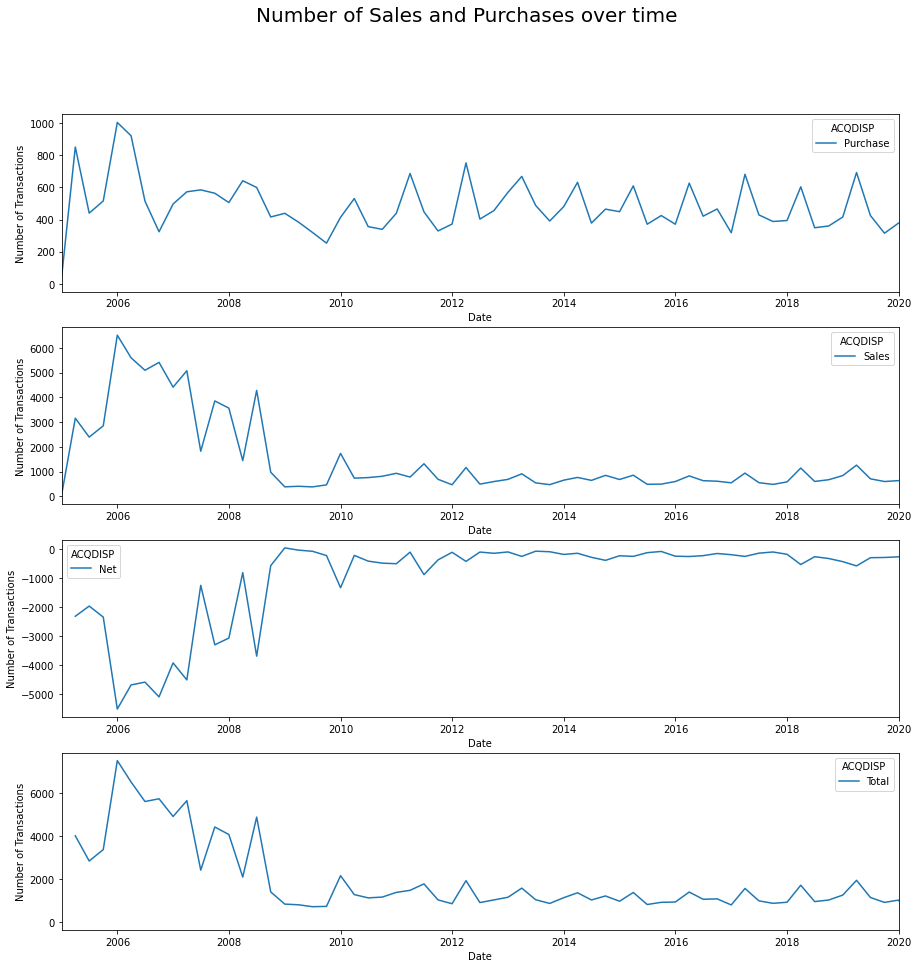

In [6]:
plot_graph_fig3()

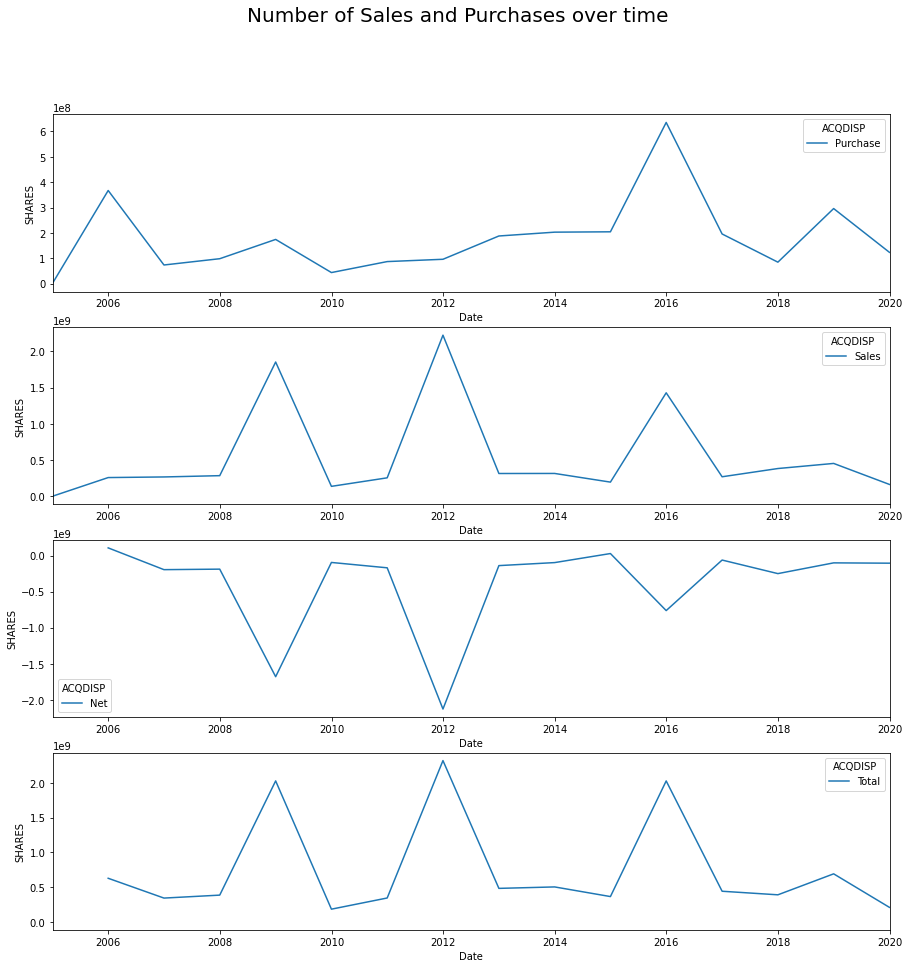

In [5]:
plot_graph_fig3("SHARES")

# 3.6 Check if data is correct

In [1]:
from IPython.core.display import display, HTML

In [3]:
def display_table_with_html(df):
    display(HTML(df.to_html(escape=False)))

def vet_sample_data():

    df1 = setup_df()
    cleanup_nums = {
        "ACQDISP": {
            1: "Purchase",
            2: "Sales"
        },
        "Role Code": {
            1: "Director",
            2: "Officer",
            3: "Owner",
            4: "Other"
        },
    }
    df1 = df1.replace(cleanup_nums)
    display_table_with_html(df1.sample())
    